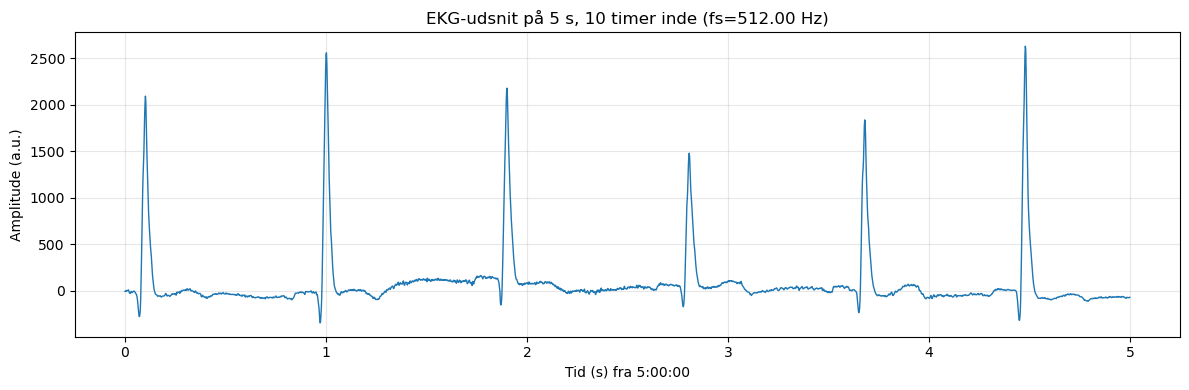

fs = 512.000 Hz | segment [18432000 : 18434560] af i alt 82460288


In [13]:
# --- Sanity check: vis 25 s EKG 5 timer inde i en TDMS-optagelse ---
# Kræver: pip install nptdms matplotlib numpy

from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

def load_tdms_segment(path_tdms, start_time_s, duration_s=25.0, channel_name=None, fs_override=None):
    """
    Returnerer (t, x, fs, meta) for et udsnit af længde 'duration_s' der starter 'start_time_s' sekunder
    efter optagelsesstart. Vælger første kanal hvis channel_name ikke angives.
    """
    td = TdmsFile.read(str(path_tdms))

    # Vælg gruppe/kanal
    g = td.groups()[0]
    ch = None
    if channel_name is None:
        ch = g.channels()[0]
    else:
        for c in g.channels():
            if c.name == channel_name:
                ch = c
                break
        if ch is None:
            raise ValueError(f"Kanalen '{channel_name}' blev ikke fundet. Tilgængelige: {[c.name for c in g.channels()]}")

    # Rådata (float)
    x_all = ch.data.astype(float)

    # Samplingfrekvens
    inc = ch.properties.get("wf_increment", None)  # sekunder/sample
    fs = None
    if inc is not None:
        fs = 1.0 / inc
    if fs_override is not None:
        fs = fs_override
    if fs is None:
        raise ValueError("Samplingfrekvens kunne ikke bestemmes (wf_increment mangler). Angiv fs_override.")

    # Starttid (hvis tilgængelig – kun til info)
    wf_start = ch.properties.get("wf_start_time", None)
    # Bemærk: vi bruger uanset hvad 'start_time_s' relativt til filstart

    # Indeksberegning
    n0 = int(round(start_time_s * fs))
    n1 = n0 + int(round(duration_s * fs))
    if n0 < 0:
        raise ValueError("Startindeks bliver negativt – tjek start_time_s.")
    if n0 >= len(x_all):
        raise ValueError("Start ligger efter filens slutning.")
    n1 = min(n1, len(x_all))

    x = x_all[n0:n1]
    t = np.arange(len(x)) / fs  # lokal tidsskala (sekunder)

    meta = {
        "fs": fs,
        "n_total": len(x_all),
        "segment_start_index": n0,
        "segment_end_index": n1,
        "wf_start_time": wf_start,  # kan være None
    }
    return t, x, fs, meta

# -----------------------------
# KONFIGURATION
patientId = 5
path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
   # <-- SKIFT denne
channel = None                     # fx "ECG" eller lad None for første kanal
fs_override = None                 # fx 256.0 hvis wf_increment mangler
hours_after_start = 10.0            # 5 timer
duration_s = 5.0                  # 25 sekunder
# -----------------------------

start_time_s = hours_after_start * 3600.0
t, x, fs, meta = load_tdms_segment(path, start_time_s, duration_s, channel, fs_override)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, x, lw=1)
plt.xlabel("Tid (s) fra 5:00:00")
plt.ylabel("Amplitude (a.u.)")
title_right = ""
if meta["wf_start_time"] is not None:
    # vis human læsbar absolut start for segmentet (hvis tilgængeligt)
    try:
        abs_seg_start = meta["wf_start_time"] + timedelta(seconds=start_time_s)
        title_right = f" | Segment starter: {abs_seg_start}"
    except Exception:
        pass

plt.title(f"EKG-udsnit på {duration_s:.0f} s, {hours_after_start:.0f} timer inde (fs={meta['fs']:.2f} Hz){title_right}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"fs = {meta['fs']:.3f} Hz | segment [{meta['segment_start_index']} : {meta['segment_end_index']}] af i alt {meta['n_total']}")
